# Image Captioning using LSTMs

## Summary

This notebook was created using a comination of two sources: https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/ and https://github.com/yashk2810/Image-Captioning/blob/master/Image%20Captioning%20InceptionV3.ipynb

The dataset used for the testing and training was the Flickr8k which can be found easily online.

In [149]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, add, Embedding, Dropout, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Concatenate, Input
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

In [198]:
token = '145129_343604_bundle_archive/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'

In [3]:
captions = open(token, 'r').read().strip().split('\n')

# Creating dictionaries for the images

We'll create a dictionary from the image to the captions. This is so that when we train/test the images we'll easily be able to reference the captions from the images.

In [7]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0]) -2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [8]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
images = '145129_343604_bundle_archive/Flickr_Data/Flickr_Data/Images/'

In [13]:
img = glob.glob(images+'*.jpg')

## Now we are splitting up the test/train/validation data sets

We use split_data to take the files of the images and put them into lists that are easy for us to manipulate

In [199]:
train_images_file = '145129_343604_bundle_archive/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'

In [16]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [17]:
def split_data(data):
    temp = []
    for i in img:
        if i[len(images):] in data:
            temp.append(i)
    return temp

In [18]:
train_img = split_data(train_images)
len(train_img)

6000

In [201]:
val_images_file = '145129_343604_bundle_archive/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [20]:
val_img = split_data(val_images)
len(val_img)

1000

In [21]:
test_images_file = '145129_343604_bundle_archive/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [22]:
test_img = split_data(test_images)
len(test_img)

1000

Voila! Here is one of the images from the dataset!

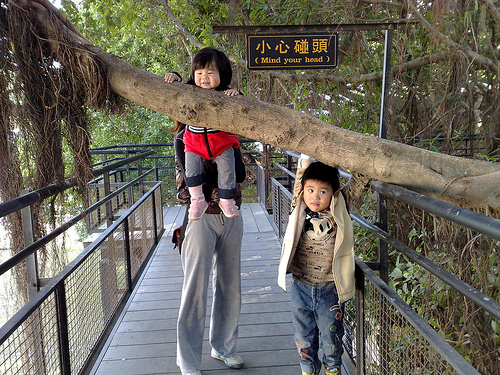

In [31]:
Image.open(train_img[7])

# Image PreProcessing

Next we're going to preprocess the images. Because image captioning has two parts (CNN -> LSTM) we do the parts associated with identifying valuable information from the images first. Essentially we will be running each image through a CNN, but removing the final classification step so we can use that raw vector as an input to the LSTM for image captioning purposes.

In [37]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [38]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


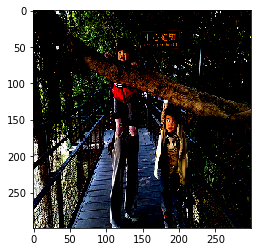

In [39]:
plt.imshow(np.squeeze(preprocess(train_img[7])))

### Creating the CNN model

In [41]:
model = InceptionV3(weights = 'imagenet')

In [42]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

### Encoding the images using the CNN

In this section we will be storing the cnn encoded images into a file so we can easily use them later on.

In [46]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [48]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

100%|██████████| 6000/6000 [17:33<00:00,  5.69it/s]


In [49]:
with open("145129_343604_bundle_archive/Flickr_Data/Flickr_Data/encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [50]:
encoding_train = pickle.load(open("145129_343604_bundle_archive/Flickr_Data/Flickr_Data/encoded_images_inceptionV3.p", 'rb'))

In [51]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

In [59]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|██████████| 1000/1000 [02:35<00:00,  6.44it/s]


In [60]:
with open("145129_343604_bundle_archive/Flickr_Data/Flickr_Data/encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [61]:
encoding_test = pickle.load(open("145129_343604_bundle_archive/Flickr_Data/Flickr_Data/encoded_images_test_inceptionV3.p",'rb'))

In [62]:
encoding_test[test_img[0][len(images):]].shape

(2048,)

## Stores the captions for the images in a dict

In this next section we will be working with the caption text. We'll be splitting up the text and assigning each word in the entire vocabulary of the captions a unique identifying number. Something to note is that even the special characters < start > and < end > have their own values. This is because we need those values to being and end a caption we'll create.

In [64]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [65]:
len(train_d)

6000

In [66]:
train_d[images+'3556792157_d09d42bef7.jpg']

['A bunch of children sitting in chairs and standing on wooden floors .',
 'A group of children sit , stand , and kneel along a wall .',
 'A group of children sitting on folding chairs and playing .',
 'a young group of children sitting in a row against the wall .',
 'The kids talking while sitting on a row of chairs along the wall .']

In [67]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [68]:
len(val_d)


1000

In [69]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [70]:
len(test_d)

1000

### Calculate the unique words

In [71]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [72]:
words = [i.split() for i in caps]

In [74]:
unique = []
for i in words:
    unique.extend(i)

In [75]:
unique = list(set(unique))

In [77]:
len(unique)

8256

### Mapping words to indexes

In [78]:
word2idx = {val:index for index, val in enumerate(unique)}

In [79]:
word2idx['<start>']

3133

In [80]:
idx2word = {index:val for index,val in enumerate(unique)}

In [81]:
idx2word[3133]

'<start>'

#### Max length of all captions. We'll be using this value to give an upper limit of what the captions we create can be.

In [82]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [83]:
vocab_size = len(unique)

In [84]:
vocab_size

8256

### Puts the captions you created into a file for later use

In [85]:
f = open('145129_343604_bundle_archive/Flickr_Data/Flickr_Data/flickr8k_training_dataset.txt', 'w')
#creates the columns for the file you'll create
f.write("image_id\tcaptions\n")

18

In [86]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [89]:
df = pd.read_csv('145129_343604_bundle_archive/Flickr_Data/Flickr_Data/flickr8k_training_dataset.txt', delimiter='\t')

In [90]:
len(df)

30000

In [91]:
c = [i for i in df['captions']]
len(c)

30000

In [92]:
imgs = [i for i in df['image_id']]

In [93]:
a = c[-1]
a, imgs[-1]

('<start> A longeared dog running in the grass . <end>',
 '2764732789_1392e962d0.jpg')

#### You can see here that each word and special character is now assigned to a unique number. We'll be using those numbers later on for training.

In [94]:
for i in a.split():
    print(i, "->", word2idx[i])

<start> -> 3133
A -> 2332
longeared -> 3523
dog -> 3583
running -> 2154
in -> 5469
the -> 4762
grass -> 7118
. -> 5833
<end> -> 4184


In [95]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split()) -1

In [96]:
samples_per_epoch

383454

# LSTM Portion

In this section we'll be actually doing the training. The function below is a generator and is used to create data more or less on the fly that can be pumped into the model as it trains. The initial part of the function is obtaining the data from the text files we created earlier and the second part of the function in the while loop takes the data and puts it into a format that can be consumed by the model. Namely ([image, the caption predicted up until this point], the actual next word). 

In [97]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('145129_343604_bundle_archive/Flickr_Data/Flickr_Data/flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

## creating the model

Here we create the model itself which takes in two inputs. It takes in the image portion in inputs1 and the text portion in inputs2. We then combine them together in the model portion. The network itself is actually quite simple to understand when you break it up in chunks like below.

In [100]:
embedding_size = 300

In [151]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    return model

In [152]:
final_model = define_model(vocab_size,max_len)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 40, 256)      2113536     input_18[0][0]                   
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 2048)         0           input_17[0][0]                   
____________________________________________________________________________________________

## Training the model

Below we train the model. I only trained for one epoch not even using all of the data because I was just using my CPU and wanted to get some quick and dirty results. You'll see below that even with just one round of training it actually worked extremely well!

In [154]:

final_model.fit_generator(data_generator(batch_size=128), steps_per_epoch=samples_per_epoch/128, nb_epoch=1, 
                          verbose=2)

/Users/markmartinez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/Users/markmartinez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=2995.73437..., verbose=2, epochs=1)`
  


Epoch 1/1
 - 925s - loss: 2.7594


## Predicting

In [155]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [159]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

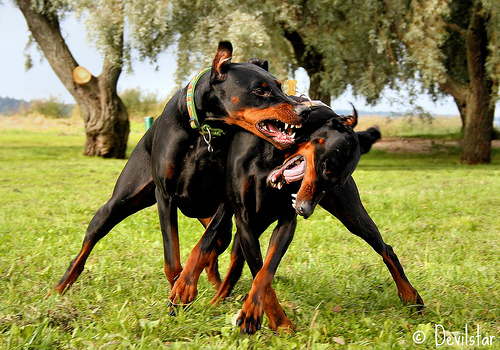

In [157]:

try_image = test_img[0]
Image.open(try_image)

In [160]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: A black dog is running through the grass .
Beam Search, k=3: A black dog runs through the grass .
Beam Search, k=5: A black dog runs through the grass .
Beam Search, k=7: A black dog runs through the grass .


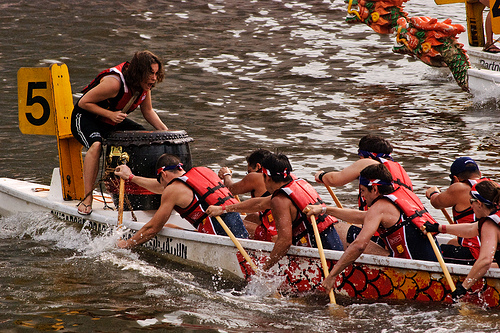

In [170]:
try_image2 = test_img[11]
Image.open(try_image2)

In [171]:
print ('Normal Max search:', predict_captions(try_image2)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image2, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image2, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image2, beam_index=7))

Normal Max search: A man is surfing a boat on a river .
Beam Search, k=3: A group of people on a boat in the water .
Beam Search, k=5: A group of people stand in the water .
Beam Search, k=7: A group of people stand in the water .


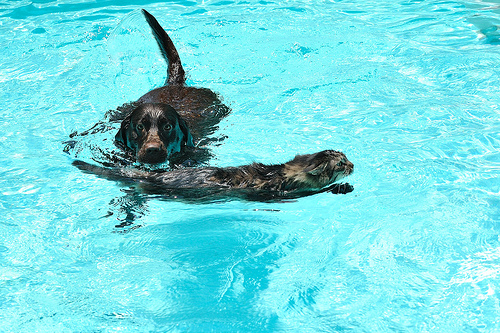

In [192]:
try_image2 = test_img[25]
Image.open(try_image2)

In [195]:
print ('Normal Max search:', predict_captions(try_image2)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image2, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image2, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image2, beam_index=7))

Normal Max search: A dog swims in the water .
Beam Search, k=3: A black dog swims in the water .
Beam Search, k=5: A black dog swims in the water .
Beam Search, k=7: A black dog swims in the water .


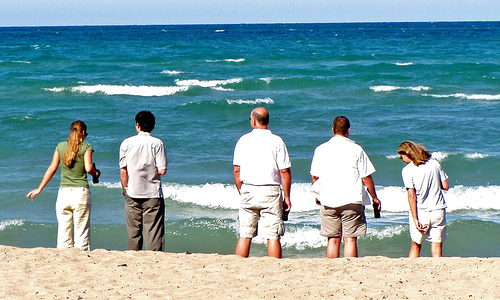

In [196]:
try_image2 = test_img[17]
Image.open(try_image2)

In [197]:
print ('Normal Max search:', predict_captions(try_image2)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image2, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image2, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image2, beam_index=7))

Normal Max search: A man in a bikini is standing on the beach .
Beam Search, k=3: A woman in a swimsuit is standing on the beach .
Beam Search, k=5: A woman in a swimsuit is standing on the beach .
Beam Search, k=7: A woman in a red shirt is walking on the beach .
